In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import uncertainties as un
from matplotlib import pyplot as plt
from uncertainties import unumpy as unp

from funcs.dir import d_drive
from funcs.post_processing.images.soot_foil.deltas import get_px_deltas_from_lines, Shot

sns.set_palette("colorblind")

In [2]:
DF_SPATIAL = pd.read_csv(
    os.path.join(
        d_drive,
        "Data",
        "Processed",
        "Soot Foil",
        "spatial_calibrations.csv"
    )
)
shots_to_test = (
    Shot("2020-11-13", 7),
    Shot("2020-11-23", 0),
    Shot("2020-11-23", 2),
    Shot("2020-11-23", 5),
    Shot("2020-11-24", 1),
    Shot("2020-11-24", 2),
    Shot("2020-11-24", 6),
    Shot("2020-11-25", 1),
    Shot("2020-11-25", 2),
    Shot("2020-11-25", 3),
    Shot("2020-11-26", 1),
    Shot("2020-11-26", 2),
    Shot("2020-11-26", 3),
    Shot("2020-11-26", 4),
    Shot("2020-11-26", 5),
    Shot("2020-11-26", 6),
    Shot("2020-12-07", 0),
    Shot("2020-12-07", 1),
    Shot("2020-12-07", 3),
    Shot("2020-12-07", 4),
    Shot("2020-12-07", 5),
    Shot("2020-12-07", 6),
    Shot("2020-12-08", 2),
    Shot("2020-12-08", 3),
    Shot("2020-12-08", 4),
    Shot("2020-12-08", 5),
    Shot("2020-12-08", 6),
    Shot("2020-12-09", 0),
    Shot("2020-12-09", 2),
    Shot("2020-12-09", 3),
    Shot("2020-12-09", 6),
    Shot("2020-12-09", 8),
    Shot("2020-12-10", 0),
    Shot("2020-12-10", 1),
    Shot("2020-12-10", 3),
    Shot("2020-12-10", 4),
    Shot("2020-12-10", 5),
    Shot("2020-12-10", 6),
    Shot("2020-12-10", 7),
)

In [3]:
class ImagePath:
    def __init__(self, shot: Shot, direction: int):
        shot_dir = os.path.join(d_drive, "Data", "Processed", "Soot Foil", "foil images", shot.dir_name)
        self.img = os.path.join(shot_dir, f"dir{direction}.png")
        
        mask = os.path.join(shot_dir, f"mask{direction}.png")
        if os.path.exists(mask):
            self.mask = mask
        else:
            self.mask = None


class MeasurementPaths:
    def __init__(self, shot: Shot):
        self.dir0 = ImagePath(shot, 0)
        self.dir1 = ImagePath(shot, 1)


class IsMasked:
    def __init__(self, measurement_paths):
        self.dir0 = measurement_paths.dir0.mask is not None
        self.dir1 = measurement_paths.dir1.mask is not None
        
    def __repr__(self):
        dir0 = "masked" if self.dir0 else "not masked"
        dir1 = "masked" if self.dir1 else "not masked"
        return f"dir0 {dir0}, dir1 {dir1}"


class FullDataDirectional:
    def __init__(self):
        self.nominal = np.array([])
        self.with_meas_uncertainty = np.array([])
        self.n_measurements = np.NaN
    
    def from_measured(self, measured: unp.uarray):
        self.nominal = unp.nominal_values(measured)
        self.with_meas_uncertainty = measured
        self.n_measurements = len(self.nominal)
    
    def __repr__(self):
        return f"{self.n_measurements} measurements"

class FullData:
    def __init__(self):
        self.dir0 = FullDataDirectional()
        self.dir1 = FullDataDirectional()
        self.all = FullDataDirectional()
        self.n_measurements = np.NaN
    
    def from_measured(self, dir0: unp.uarray, dir1: unp.uarray):
        self.dir0.from_measured(dir0)
        self.dir1.from_measured(dir1)
        self.all.from_measured(np.concatenate((dir0, dir1)))
        self.n_measurements = len(self.all.nominal)
    
    def __repr__(self):
        return f"{self.n_measurements} measurements"


class Result:
    def __init__(self):
        self.nominal = np.NaN
        self.std_dev = np.NaN
        self.with_meas_uncertainty = un.ufloat(np.NaN, np.NaN)
        
    def from_measured(self, measured: un.ufloat):
        self.nominal = measured.nominal_value
        self.meas_uncertainty = measured.std_dev
        self.prec_uncertainty = np.std(self.nominal)
        self.with_all_uncertainty = measured + un.ufloat(0, self.prec_uncertainty)
        
    def __repr__(self):
        return f"{self.with_all_uncertainty:.2f} mm"
        

class Measurement:
    def __init__(self, shot: Shot):
        self.shot = shot
        self.paths = MeasurementPaths(shot)
        self.is_masked = IsMasked(self.paths)
        self.full_data = FullData()
        self.result = Result()

    def collect(self, px_to_mm: float):
        dir0 = get_px_deltas_from_lines(
            img_path=self.paths.dir0.img,
            mask_path=self.paths.dir0.mask,
            use_fast=True,
            apply_uncertainty=True,
        ) * px_to_mm
        dir1 = get_px_deltas_from_lines(
            img_path=self.paths.dir1.img,
            mask_path=self.paths.dir1.mask,
            use_fast=True,
            apply_uncertainty=True,
        ) * px_to_mm
        
        self.full_data.from_measured(dir0, dir1)
        
        result = np.median(self.full_data.all.with_meas_uncertainty)
        self.result.from_measured(result)
        
        return self
        
    def __repr__(self):
        return str(self.shot)

In [4]:
def get_spatial(shot: Shot) -> float:
    this_spatial = DF_SPATIAL[(DF_SPATIAL["date"] == shot.date) & (DF_SPATIAL["shot"] == shot.shot_no)]
    if len(this_spatial):
        px_to_mm = (this_spatial["delta_mm"] / this_spatial["delta_px"]).values[0]
    else:
        px_to_mm = np.NaN
    
    return px_to_mm

In [5]:
results = []

for shot in shots_to_test:
    px_to_mm = get_spatial(shot)
    results.append(Measurement(shot).collect(px_to_mm))

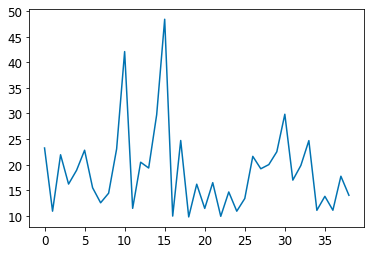

In [7]:
plt.plot([r.result.nominal for r in results])

**TODO**: move all classes into package somewhere -- Shot needs to move too

**TODO**: get tube data and add to each shot

**TODO**: make Shots class to hold all shots, run analysis, group by conditions, plot